# Домашнее задание №7

Домашняя работа
Будем работать с датасетом подержанных машин https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes.

Задача - построить прогноз цены машины по ее данным (год выпуска, пробег, расход, размер двигателя, тип коробки передач и тд).

Это задача регрессии, поэтому нужно использовать модели регрессоры, а не классификаторы (например, не StackingClassifier, а StackingRegressor).

## Easy
Взять один файл с маркой машины.

Построить прогноз, используя модели линейной регрессии и случайного леса. Сравнить результаты, используя кросс-валидацию. Подобрать гиперпараметры моделей (для линейной регрессии можно использовать реализацию с градиентным спуском SGDRegressor). Оценить качество, используя метрику r2_score. Оценить важность признаков (параметр feature_importance_ у случайного леса).

## Решение:

Импортируем все необходимое, загружаем/сохраняем информацию с kaggle по автомобилям

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

In [3]:
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

Выбираем марку авто - например skoda:
читаем файл, "присвоим" вещественным признакам (модель, трансмиссия, тип топлива) коды через get_dummies

In [4]:
skoda = pd.read_csv('./data/archive/skoda.csv')

In [5]:
skoda

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Octavia,2017,10550,Manual,25250,Petrol,150,54.3,1.4
1,Citigo,2018,8200,Manual,1264,Petrol,145,67.3,1.0
2,Octavia,2019,15650,Automatic,6825,Diesel,145,67.3,2.0
3,Yeti Outdoor,2015,14000,Automatic,28431,Diesel,165,51.4,2.0
4,Superb,2019,18350,Manual,10912,Petrol,150,40.9,1.5
...,...,...,...,...,...,...,...,...,...
6262,Yeti,2014,11440,Semi-Auto,14569,Petrol,160,44.8,1.2
6263,Octavia,2014,10990,Semi-Auto,49999,Petrol,30,56.5,1.4
6264,Fabia,2017,9500,Semi-Auto,17131,Petrol,145,61.4,1.0
6265,Citigo,2016,5999,Manual,21747,Petrol,20,62.8,1.0


In [6]:
skoda.model = pd.get_dummies(skoda.model)

In [7]:
skoda.transmission = pd.get_dummies(skoda.transmission)

In [8]:
skoda.fuelType = pd.get_dummies(skoda.fuelType)

In [9]:
skoda.head(3)  # смотрим, как выглядит датафрейм с "закодированными" качественными признаками:

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,0,2017,10550,0,25250,0,150,54.3,1.4
1,1,2018,8200,0,1264,0,145,67.3,1.0
2,0,2019,15650,1,6825,1,145,67.3,2.0


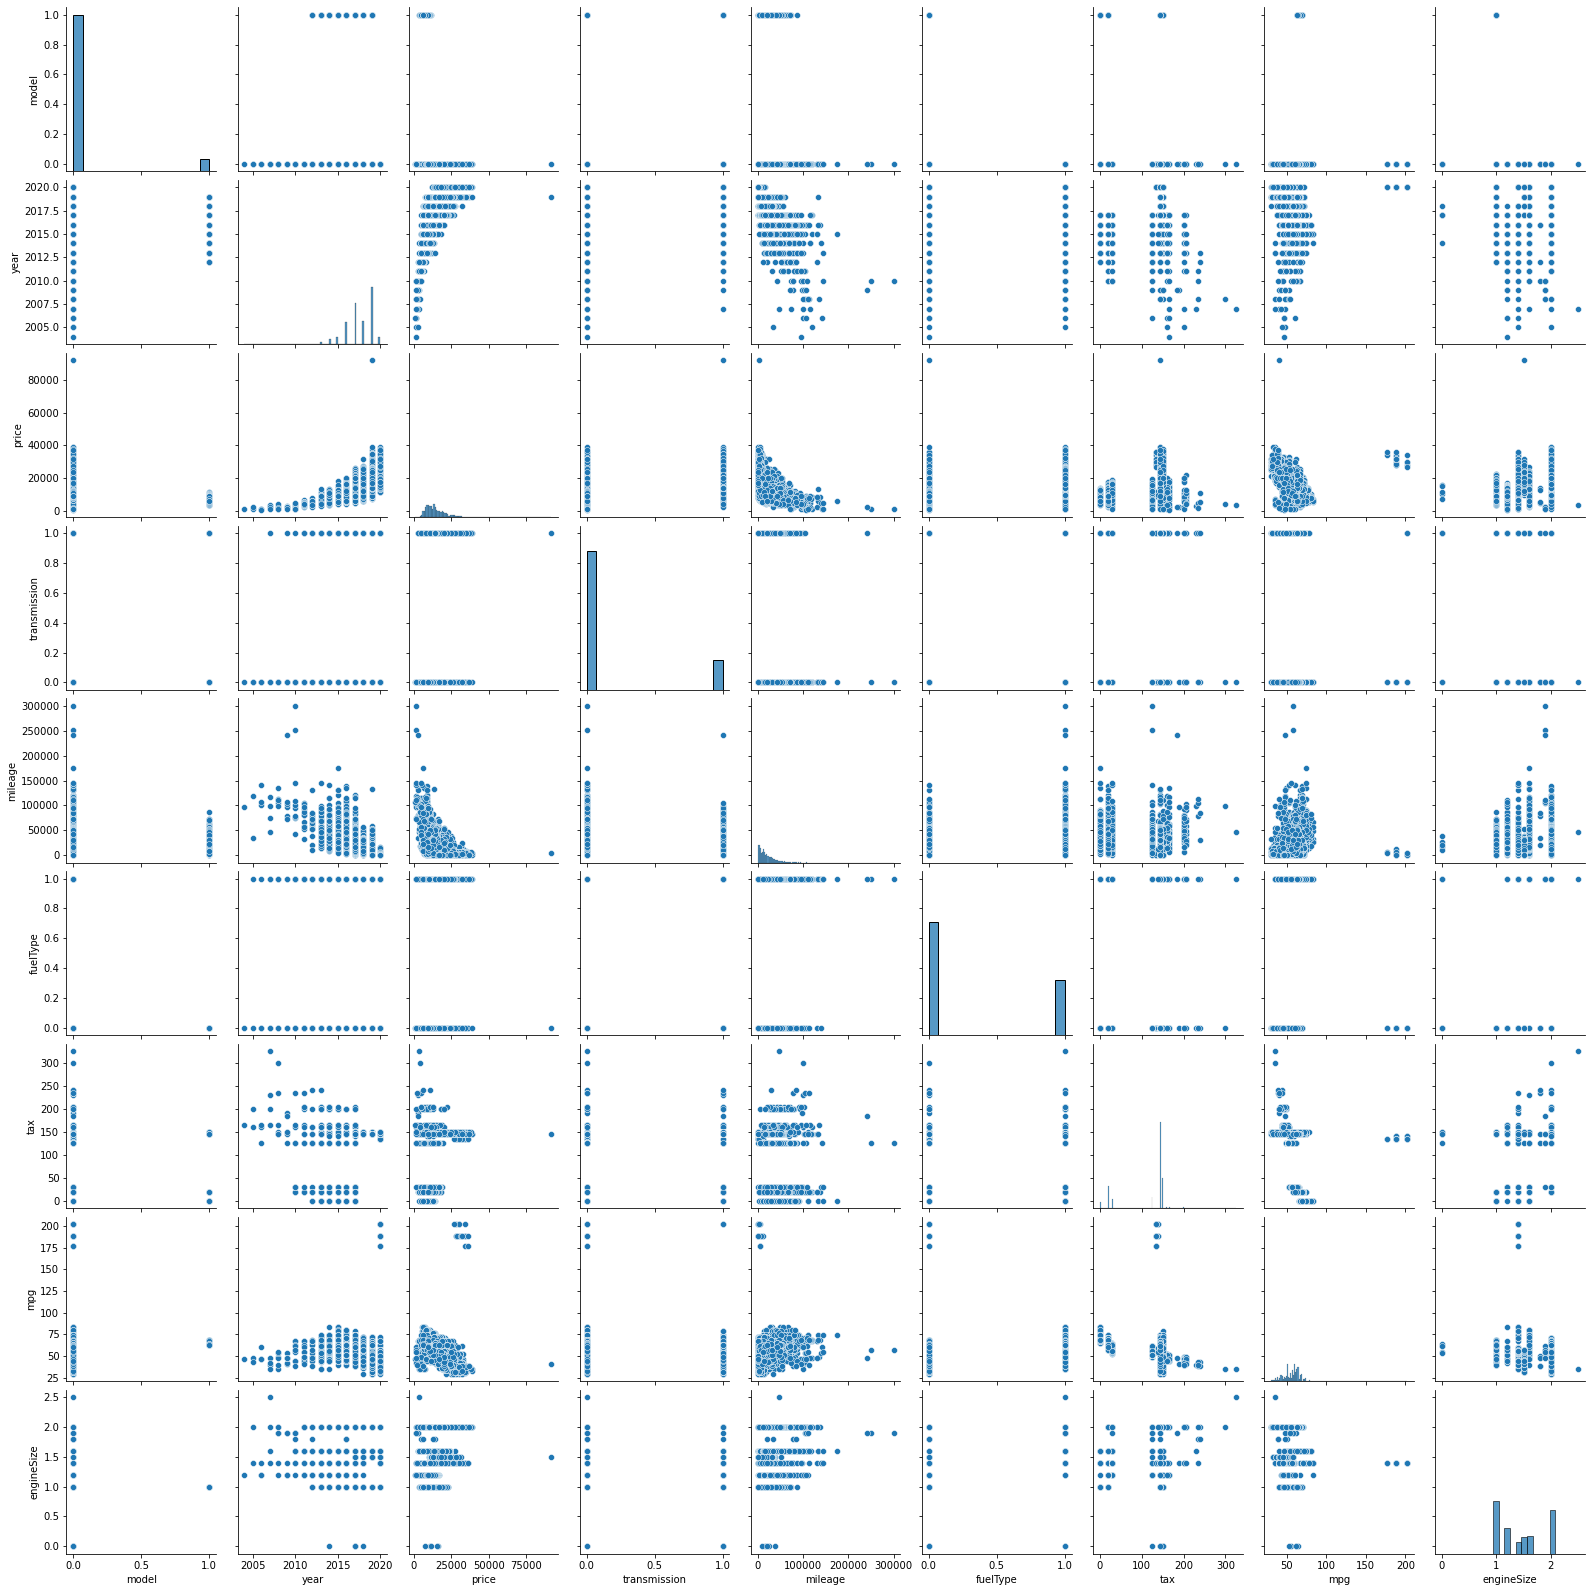

In [10]:
sns.pairplot(skoda)  # оценим визуально взаимозависимости признаков (построим диаграммы)

Сформируем датафрейм с необходимыми признаками для формирования моделей по выбранной марке на базе исходного:
год выпуска, пробег, расход топлива, размер двигателя, тип коробки передач и т.п.:

In [11]:
df = pd.DataFrame()

In [12]:
df['model'] = skoda.model
df['year'] = skoda.year
df['mileage'] = skoda.mileage
df['mpg'] = skoda.mpg
df['engineSize'] = skoda.engineSize
df['transmission'] = skoda.transmission
df['tax'] = skoda.tax
df = df.join(skoda.fuelType)

In [13]:
df

,model,year,mileage,mpg,engineSize,transmission,tax,fuelType
0,0,2017,25250,54.3,1.4,0,150,0
1,1,2018,1264,67.3,1.0,0,145,0
2,0,2019,6825,67.3,2.0,1,145,1
3,0,2015,28431,51.4,2.0,1,165,1
4,0,2019,10912,40.9,1.5,0,150,0
...,...,...,...,...,...,...,...,...
6262,0,2014,14569,44.8,1.2,0,160,0
6263,0,2014,49999,56.5,1.4,0,30,0
6264,0,2017,17131,61.4,1.0,0,145,0
6265,1,2016,21747,62.8,1.0,0,20,0


In [14]:
x = df.values
y = skoda.price.values
x_train, x_test, y_train, y_test = train_test_split(x, y)

Построим прогноз, используя модели линейной регрессии и случайного леса. Качество моделей оценивается по метрике r2_score

Модель линейной регрессии:

In [15]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
r2_lr = r2_score(y_test, y_pred)

In [16]:
print('Качество модели линейной регрессии составляет: ', r2_lr*100, '%')

Качество модели линейной регрессии составляет:  76.60664401367507 %


Модель случайного леса:

In [17]:
rf = RandomForestRegressor()  
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
r2_rf = r2_score(y_test, y_pred)

In [18]:
print('Качество модели случайного леса по r2_score составляет: ', r2_rf*100, '%')

Качество модели случайного леса по r2_score составляет:  90.90656809164908 %


In [19]:
print('Вывод по качеству моделей по r2_score:')
if r2_rf > r2_lr:
    print ('Качество модели случайного леса по r2_score выше, чем у модели линейной регрессии')
else:
    print ('Качество модели случайного леса по r2_score хуже, чем у модели линейной регрессии')

Вывод по качеству моделей по r2_score:
Качество модели случайного леса по r2_score выше, чем у модели линейной регрессии


Сравним результаты, используя кросс-валидацию:

In [20]:
print ('для модели линейной регрессии:')
cross_val_score_lr = cross_val_score(lr, x_train, y_train)
lr_result = cross_val_score(lr, x_train, y_train).mean()
print("mean составляет: ", cross_val_score_lr.mean(), " std составляет:", cross_val_score_lr.std())
print('Среднее по кросс-валидации в модели:', lr_result*100,'%')

для модели линейной регрессии:
mean составляет:  0.7590362405827189  std составляет: 0.04094955604193749
Среднее по кросс-валидации в модели: 75.90362405827189 %


In [21]:
print ('для модели случайного леса:')
scores = cross_val_score(rf, x_train, y_train)
rf_result = cross_val_score(rf, x_train, y_train).mean()
print("mean составляет: ", scores.mean(), " std составляет:", scores.std())
print('Среднее по кросс-валидации в модели:', rf_result*100,'%')

для модели случайного леса:
mean составляет:  0.8997813661473074  std составляет: 0.04048449247633264
Среднее по кросс-валидации в модели: 90.01293327466453 %


In [22]:
print('Вывод по качеству моделей по кросс-валидации:')
if rf_result > lr_result:
    print ('Качество модели случайного леса по кросс-валидации выше, чем у модели линейной регрессии')
else:
    print ('Качество модели случайного леса по кросс-валидации хуже, чем у модели линейной регрессии')

Вывод по качеству моделей по кросс-валидации:
Качество модели случайного леса по кросс-валидации выше, чем у модели линейной регрессии


Оценим важность признаков (параметр feature_importance_ у случайного леса).

In [23]:
rf.feature_importances_

array([0.01138274, 0.18609466, 0.1048953 , 0.51036761, 0.13955509,
       0.00876374, 0.02050331, 0.01843755])

In [24]:
rf.feature_importances_.max()  # находим признак с наибольшим определяющим весом

0.5103676120795823

In [25]:
print('Вывод по важности признаков:')
print('Наибольший вес - у элемента ', rf.feature_importances_.max(), '- miles per gallon. Это главный определяющий признак')

Вывод по важности признаков:
Наибольший вес - у элемента  0.5103676120795823 - miles per gallon. Это главный определяющий признак


Остальные признаки идут от него с большим отрывом (на 2ом месте год выпуска)

Подберем гиперпараметры моделей -

Выберем параметры (основные) и применим RandomizedSearchCV и GridSearchCV -

In [26]:
params = {
    'n_estimators': [2, 5, 7],
    'min_samples_split': [2, 3],
    'max_depth': [2, 8, 10]
}

RandomizedSearchCV к модели случайного леса

In [27]:
r_search = RandomizedSearchCV(RandomForestRegressor(), params)
r_search.fit(x_train, y_train)
r_search.best_estimator_

RandomForestRegressor(max_depth=8, n_estimators=5)

GridSearchCV к модели случайного леса -

In [28]:
gr_search = GridSearchCV(RandomForestRegressor(), params)
gr_search.fit(x_train, y_train)
gr_search.best_estimator_

RandomForestRegressor(max_depth=10, min_samples_split=3, n_estimators=7)

Оценим качество модели случайного леса при подборе параметров:

In [29]:
y_pred = r_search.best_estimator_.predict(x_test)
r2_r2 = r2_score(y_test, y_pred)
print('Качество модели RandomForest при RandomizedSearch составляет: ', r2_r2*100, '%')

Качество модели RandomForest при RandomizedSearch составляет:  92.16599910506302 %


In [30]:
y_pred = gr_search.best_estimator_.predict(x_test)
r2_r2_g = r2_score(y_test, y_pred)
print('Качество модели RandomForest при GridSearch составляет: ', r2_r2_g*100, '%')

Качество модели RandomForest при GridSearch составляет:  88.93895449233982 %


Наилучшее качество из рассмотренных моделей по r2_score - у модели RandomForest при подборе параметров RandomizedSearch.

Для модели линейной регрессии:

Для линейной регрессии можно используем реализацию с градиентным спуском SGDRegressor

In [32]:
lr_SGD = SGDRegressor()
lr_SGD.fit(x_train, y_train)
y_pred = lr_SGD.predict(x_test)
r2_lr_SGD = r2_score(y_test, y_pred)
r2_lr_SGD
print('Качество модели SGDRegressor по r2_score составляет: ', r2_lr_SGD*100, '%')
print('Такое может быть, если модель отработала хуже, чем среднее')

Качество модели SGDRegressor по r2_score составляет:  -1.5814576225467385e+28 %
Такое может быть, если модель отработала хуже, чем среднее


При подборе параметров и применении RandomizedSearchCV и GridSearchCV к модели линейной регрессии:

In [33]:
# применим варианты параметров:

params = {
    'fit_intercept': [2, 5, 7],
    'normalize': [3, 6, 9],
    'n_jobs': [3, 8, 10]
}

RandomizedSearchCV к модели LinearRegression

In [34]:
lr_search = RandomizedSearchCV(LinearRegression(), params)
lr_search.fit(x_train, y_train)
lr_search.best_estimator_

LinearRegression(fit_intercept=5, n_jobs=8, normalize=6)

GridSearchCV к модели линейной регрессии:

In [35]:
lr_search_1 = GridSearchCV(LinearRegression(), params)
lr_search_1.fit(x_train, y_train)
lr_search_1.best_estimator_

LinearRegression(fit_intercept=2, n_jobs=3, normalize=3)

In [36]:
y_pred = lr_search.best_estimator_.predict(x_test)
r2_lr2 = r2_score(y_test, y_pred)
print('Качество модели линейной регрессии при RandomizedSearch составляет: ', r2_lr2*100, '%')

Качество модели линейной регрессии при RandomizedSearch составляет:  76.60664401367522 %


In [37]:
y_pred = lr_search_1.best_estimator_.predict(x_test)
r2_lr2_1 = r2_score(y_test, y_pred)
print('Качество модели линейной регрессии при GridSearch также составляет: ', r2_lr2_1*100, '%')

Качество модели линейной регрессии при GridSearch также составляет:  76.60664401367522 %


In [38]:
r2_lr2_1 == r2_lr2  # видим, что результаты поиска и по GridSerarch, и по RandomizedSearch для модели Линейной регрессии равны - True

True

In [39]:
print('Можно сделать вывод:')
if r2_lr2 > r2_lr:
    print('Качество модели линейной регрессии с учетом найденных параметров лучше стандартного варианта и составляет %', r2_lr2*100)
    print('против стандартного варианта -', r2_lr*100)
else:
    print('Качество модели линейной регрессии с учетом найденных параметров не лучше стандартного варианта, для которого оно составило  в %', 
          r2_lr*100)
        

Можно сделать вывод:
Качество модели линейной регрессии с учетом найденных параметров лучше стандартного варианта и составляет % 76.60664401367522
против стандартного варианта - 76.60664401367507


При этом отличия незначительны

Вывод: в целом, наилучшие результаты из представленных вариантов по r2_score дает модель RandomForest

## Normal


Объединить в один датафрейм данные по всем маркам машин. Преобразовать категориальные признаки.

Построить еще несколько моделей, используя подбор гиперпараметров. Сравнить между собой все построенные модели.

In [40]:
import random as rnd

In [41]:
import os

Читаем данные, смотрим на соответствие столбцов/данных во всех датафреймах по маркам автомобилей:

In [42]:
audi = pd.read_csv('./data/archive/audi.csv')
bmw = pd.read_csv('./data/archive/bmw.csv')
cclass = pd.read_csv('./data/archive/cclass.csv')
focus = pd.read_csv('./data/archive/focus.csv')
ford = pd.read_csv('./data/archive/ford.csv')
hyundi = pd.read_csv('./data/archive/hyundi.csv')
merc = pd.read_csv('./data/archive/merc.csv')
skoda = pd.read_csv('./data/archive/skoda.csv')
toyota = pd.read_csv('./data/archive/toyota.csv')
vauxhall = pd.read_csv('./data/archive/vauxhall.csv')
vw = pd.read_csv('./data/archive/vw.csv')

In [43]:
audi.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


In [44]:
bmw.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In [45]:
cclass.head()

,model,year,price,transmission,mileage,fuelType,engineSize
0,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,C Class,2020,37899,Automatic,500,Diesel,2.0
3,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,C Class,2019,29899,Automatic,4500,Diesel,2.0


In [46]:
focus.head()

,model,year,price,transmission,mileage,fuelType,engineSize
0,Focus,2016,8000,Manual,38852,Petrol,1.0
1,Focus,2019,13400,Manual,11952,Petrol,1.0
2,Focus,2019,14600,Manual,22142,Petrol,1.5
3,Focus,2016,9450,Manual,14549,Diesel,1.6
4,Focus,2015,9999,Manual,7010,Diesel,1.6


In [47]:
ford.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0


In [48]:
hyundi.head()

,model,year,price,transmission,mileage,fuelType,tax(£),mpg,engineSize
0,I20,2017,7999,Manual,17307,Petrol,145,58.9,1.2
1,Tucson,2016,14499,Automatic,25233,Diesel,235,43.5,2.0
2,Tucson,2016,11399,Manual,37877,Diesel,30,61.7,1.7
3,I10,2016,6499,Manual,23789,Petrol,20,60.1,1.0
4,IX35,2015,10199,Manual,33177,Diesel,160,51.4,2.0


In [49]:
hyundi.rename(columns= {'tax(£)': 'tax'})
hyundi.head()

,model,year,price,transmission,mileage,fuelType,tax(£),mpg,engineSize
0,I20,2017,7999,Manual,17307,Petrol,145,58.9,1.2
1,Tucson,2016,14499,Automatic,25233,Diesel,235,43.5,2.0
2,Tucson,2016,11399,Manual,37877,Diesel,30,61.7,1.7
3,I10,2016,6499,Manual,23789,Petrol,20,60.1,1.0
4,IX35,2015,10199,Manual,33177,Diesel,160,51.4,2.0


In [50]:
merc.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,SLK,2005,5200,Automatic,63000,Petrol,325,32.1,1.8
1,S Class,2017,34948,Automatic,27000,Hybrid,20,61.4,2.1
2,SL CLASS,2016,49948,Automatic,6200,Petrol,555,28.0,5.5
3,G Class,2016,61948,Automatic,16000,Petrol,325,30.4,4.0
4,G Class,2016,73948,Automatic,4000,Petrol,325,30.1,4.0


In [51]:
skoda.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Octavia,2017,10550,Manual,25250,Petrol,150,54.3,1.4
1,Citigo,2018,8200,Manual,1264,Petrol,145,67.3,1.0
2,Octavia,2019,15650,Automatic,6825,Diesel,145,67.3,2.0
3,Yeti Outdoor,2015,14000,Automatic,28431,Diesel,165,51.4,2.0
4,Superb,2019,18350,Manual,10912,Petrol,150,40.9,1.5


In [52]:
toyota.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [53]:
vauxhall.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Corsa,2018,7885,Manual,9876,Petrol,145,55.4,1.4
1,Corsa,2019,11995,Manual,2500,Petrol,145,54.3,1.4
2,Corsa,2017,9777,Automatic,9625,Petrol,145,47.9,1.4
3,Corsa,2016,8500,Manual,25796,Petrol,30,55.4,1.4
4,Corsa,2019,10000,Manual,3887,Petrol,145,43.5,1.4


In [54]:
vw.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,T-Roc,2019,25000,Automatic,13904,Diesel,145,49.6,2.0
1,T-Roc,2019,26883,Automatic,4562,Diesel,145,49.6,2.0
2,T-Roc,2019,20000,Manual,7414,Diesel,145,50.4,2.0
3,T-Roc,2019,33492,Automatic,4825,Petrol,145,32.5,2.0
4,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5


Выбираем случайным образом строки из датафреймов с автомобилями c помощью random.permutation:

In [55]:
audi = audi.take(np.random.permutation(len(audi))[:2000])
bmw = bmw.take(np.random.permutation(len(bmw))[:2000])
cclass = cclass.take(np.random.permutation(len(cclass))[:2000])
focus = focus.take(np.random.permutation(len(focus))[:2000])
ford = ford.take(np.random.permutation(len(ford))[:2000])
hyundi = hyundi.take(np.random.permutation(len(hyundi))[:2000])
merc = merc.take(np.random.permutation(len(merc))[:2000])
skoda = skoda.take(np.random.permutation(len(skoda))[:2000])
toyota = toyota.take(np.random.permutation(len(toyota))[:2000])
vauxhall = vauxhall.take(np.random.permutation(len(vauxhall))[:2000])
vw = vw.take(np.random.permutation(len(vw))[:2000])

Формируем объединенный датафрейм по всем авто:

In [56]:
unitedf = pd.concat([audi, bmw, cclass, focus, ford, hyundi, merc, skoda, toyota, vauxhall, vw])
unitedf

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,tax(£)
7310,A1,2017,13500,Manual,13000,Petrol,150.0,67.3,1.0,NaN
7763,SQ5,2017,36990,Automatic,22216,Petrol,145.0,34.0,3.0,NaN
1084,A4,2016,15256,Manual,25214,Diesel,0.0,74.3,2.0,NaN
6442,A5,2019,37295,Automatic,3000,Diesel,145.0,45.6,2.0,NaN
2446,Q3,2015,14355,Manual,50228,Diesel,125.0,60.1,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...
503,T-Roc,2020,27980,Manual,1000,Petrol,145.0,42.2,1.5,NaN
12718,Up,2020,9490,Manual,6000,Petrol,145.0,54.3,1.0,NaN
2204,Golf,2016,12700,Manual,38390,Petrol,30.0,53.3,1.4,NaN
4235,Golf,2017,14247,Manual,37958,Petrol,20.0,60.1,1.4,NaN


In [57]:
unitedf = unitedf.drop('tax(£)', 1)

In [58]:
unitedf = unitedf.fillna(0.0)

"Превращаем" вещественные признаки в категории:

In [59]:
unitedf.model = pd.get_dummies(unitedf.model)
unitedf.transmission = pd.get_dummies(unitedf.transmission)
unitedf.fuelType = pd.get_dummies(unitedf.fuelType)

In [60]:
dfnew = pd.DataFrame()
dfnew['model'] = unitedf.model
dfnew['year'] = unitedf.year
dfnew['mileage'] = unitedf.mileage
dfnew['mpg'] = unitedf.mpg
dfnew['engineSize'] = unitedf.engineSize
dfnew['transmission'] = unitedf.transmission
dfnew['tax'] = unitedf.tax
dfnew['fuelType'] = unitedf.fuelType
dfnew

,model,year,mileage,mpg,engineSize,transmission,tax,fuelType
7310,0,2017,13000,67.3,1.0,0,150.0,0
7763,0,2017,22216,34.0,3.0,1,145.0,0
1084,0,2016,25214,74.3,2.0,0,0.0,1
6442,0,2019,3000,45.6,2.0,1,145.0,1
2446,0,2015,50228,60.1,2.0,0,125.0,1
...,...,...,...,...,...,...,...,...
503,0,2020,1000,42.2,1.5,0,145.0,0
12718,0,2020,6000,54.3,1.0,0,145.0,0
2204,0,2016,38390,53.3,1.4,0,30.0,0
4235,0,2017,37958,60.1,1.4,0,20.0,0


Формируем наборы данных:

In [61]:
x = dfnew.values
y = unitedf.price.values
x_train, x_test, y_train, y_test = train_test_split(x, y)

Применяем модель RandomForestRegressor и оценим качество модели:

In [62]:
rf_1 = RandomForestRegressor()
rf_1.fit(x_train, y_train)
y_pred = rf_1.predict(x_test)
r2_rf = r2_score(y_test, y_pred)

In [63]:
print('Качество модели RandomForest по r2_score составляет:', r2_rf*100, '%')

Качество модели RandomForest по r2_score составляет: 86.55395924917428 %


Проведем подбор гиперпараметров для RandomForestRegressor с помощью RandomizedSearchCV:

In [64]:
params = {
    'n_estimators': [2, 5, 7],
    'min_samples_split': [2, 3],
    'max_depth': [2, 8, 10]
}

In [65]:
search = RandomizedSearchCV(RandomForestRegressor(), params)
search.fit(x_train, y_train)
search.best_estimator_

RandomForestRegressor(max_depth=10, n_estimators=7)

In [66]:
y_pred = search.predict(x_test)
r2_rf_search = r2_score(y_test, y_pred)

In [67]:
print('Качество модели RandomForest по r2_score при подборе параметров составляет:', r2_rf_search*100, '%')

Качество модели RandomForest по r2_score при подборе параметров составляет: 86.14932750773274 %


In [68]:
print('Вывод')
if r2_rf_search > r2_rf:
    print('Качество (точность) модели RandomForest при подборе параметров не улучшилось и составило по r2_score =', r2_rf_search*100, '%')
else:
    print('Качество (точность) модели RandomForest при подборе гиперпараметров улучшилось и составило по r2_score =', r2_rf_search*100, '%')

Вывод
Качество (точность) модели RandomForest при подборе гиперпараметров улучшилось и составило по r2_score = 86.14932750773274 %


Модель линейной регрессии:

In [69]:
lr_1 = LinearRegression()
lr_1.fit(x_train, y_train)
y_pred = lr_1.predict(x_test)
r2_lr_1 = r2_score(y_test, y_pred)

In [70]:
print('Качество модели LinearRegression по r2_score составляет:', r2_lr_1*100, '%')

Качество модели LinearRegression по r2_score составляет: 71.93356666464956 %


Проведем подбор гиперпараметров для LinearRegression с помощью RandomizedSearchCV:

In [71]:
params = {
    'fit_intercept': [2, 3, 5],
    'normalize': [3, 7, 9],
    'n_jobs': [3, 8, 9]
}

In [72]:
lr_search = RandomizedSearchCV(LinearRegression(), params)
lr_search.fit(x_train, y_train)
lr_search.best_estimator_

LinearRegression(fit_intercept=2, n_jobs=3, normalize=9)

Оценим качество модели линейной регрессии при подборе параметров:

In [73]:
y_pred = lr_search.best_estimator_.predict(x_test)
r2_lr_search = r2_score(y_test, y_pred)
print('Качество модели RandomForest при RandomizedSearch составляет: ', r2_lr_search*100, '%')

Качество модели RandomForest при RandomizedSearch составляет:  71.93356666465017 %


In [74]:
print('Можно сделать вывод:')

Можно сделать вывод:


In [84]:
maximum_quality = max(r2_rf, r2_rf_search, r2_lr_1, r2_lr_search)
minimum_quality = min(r2_rf, r2_rf_search, r2_lr_1, r2_lr_search)

In [85]:
print('По r2_score при сравнении моделей между собой:')
if maximum_quality == r2_rf:
    print('Наилучшее качество у модели RandomForestRegressor до подбора гиперпараметров, в %ах составляет:', r2_rf*100)
    print('Качество (точность) модели RandomForest лучше модели линейной регрессии')
elif maximum_quality == r2_rf_search:
    print('Наилучшее качество у модели RandomForestRegressor с подбором гиперпараметров, в %ах составляет:', r2_rf_search*100)
    print('Качество (точность) модели RandomForest лучше модели линейной регрессии')
elif maximum_quality == r2_lr_1:
    print('Наилучшее качество у модели LinearRegression до подбора гиперпараметров, в %ах составляет:', r2_lr_1*100)
    print('Качество (точность) модели линейной регрессии лучше модели RandomForest')
else:
    print('Наилучшее качество у модели LinearRegression с подбором гиперпараметров, в %ах составляет:', r2_lr_search*100)
    print('Качество (точность) модели линейной регрессии лучше модели RandomForest')
print('')
print('В отношении наихудшего варианта при сравнении моделей по r2_score между собой:') 
if minimum_quality == r2_rf:
    print('Наихудшее качество у модели RandomForestRegressor до подбора гиперпараметров, в %ах составляет:', r2_rf*100)
elif minimum_quality == r2_rf_search:
    print('Наихудшее качество у модели RandomForestRegressor с подбором гиперпараметров, в %ах составляет:', r2_rf_search*100)
elif minimum_quality == r2_lr_1:
    print('Наихудшее качество у модели LinearRegression до подбора гиперпараметров, в %ах составляет:', r2_lr_1*100)
else:
    print('Наихудшее качество у модели LinearRegression с подбором гиперпараметров, в %ах составляет:', r2_lr_search*100)

По r2_score при сравнении моделей между собой:
Наилучшее качество у модели RandomForestRegressor до подбора гиперпараметров, в %ах составляет: 86.55395924917428
Качество (точность) модели RandomForest лучше модели линейной регрессии

В отношении наихудшего варианта при сравнении моделей по r2_score между собой:
Наихудшее качество у модели LinearRegression до подбора гиперпараметров, в %ах составляет: 71.93356666464956


In [77]:
print('Сравним по кросс-валидации:')
print ('для модели линейной регрессии:')
cross_val_score_lr_1 = cross_val_score(lr_1, x_train, y_train)
print("mean составляет: ", cross_val_score_lr_1.mean(), " std составляет:", cross_val_score_lr_1.std())
lr_result_1 = cross_val_score(lr_1, x_train, y_train).mean()
print('Среднее по кросс-валидации в модели:', lr_result_1*100,'%')

Сравним по кросс-валидации:
для модели линейной регрессии:
mean составляет:  0.7134624552931872  std составляет: 0.016702941947407984
Среднее по кросс-валидации в модели: 71.34624552931872 %


In [78]:
print ('для модели линейной регрессии с подбором гиперпараметров:')
cross_val_score_lr_2 = cross_val_score(lr_search, x_train, y_train)
print("mean составляет: ", cross_val_score_lr_2.mean(), " std составляет:", cross_val_score_lr_2.std())
lr_result_2 = cross_val_score(lr_search, x_train, y_train).mean()
print('Среднее по кросс-валидации в модели:', lr_result_2*100,'%')

для модели линейной регрессии с подбором гиперпараметров:
mean составляет:  0.7134624552931842  std составляет: 0.016702941947415784
Среднее по кросс-валидации в модели: 71.34624552931842 %


In [79]:
print ('для модели случайного леса:')
cross_val_score_rf_1 = cross_val_score(rf_1, x_train, y_train)
print("mean составляет: ", cross_val_score_rf_1.mean(), " std составляет:", cross_val_score_rf_1.std())
rf_result_1 = cross_val_score(rf_1, x_train, y_train).mean()
print('Среднее по кросс-валидации в модели:', rf_result_1*100,'%')

для модели случайного леса:
mean составляет:  0.8720590013873343  std составляет: 0.00404560563269818
Среднее по кросс-валидации в модели: 87.15239742423272 %


In [80]:
print ('для модели случайного леса с подбором гиперпараметров:')
cross_val_score_rf_2 = cross_val_score(search, x_train, y_train)
print("mean составляет: ", cross_val_score_rf_2.mean(), " std составляет:", cross_val_score_rf_2.std())
rf_result_2 = cross_val_score(search, x_train, y_train).mean()
print('Среднее по кросс-валидации в модели:', rf_result_2*100,'%')

для модели случайного леса с подбором гиперпараметров:
mean составляет:  0.8594649330403362  std составляет: 0.0062877697062862
Среднее по кросс-валидации в модели: 85.91878578438778 %


In [81]:
maximum_quality_cv = max(lr_result_1, lr_result_2, rf_result_1, rf_result_2)
minimum_quality_cv = min(lr_result_1, lr_result_2, rf_result_1, rf_result_2)

In [82]:
print('По кросс-валидации при сравнении моделей между собой:')
if maximum_quality_cv == rf_result_1:
    print('Наилучшее качество у модели RandomForestRegressor до подбора гиперпараметров, в %ах составляет:', rf_result_1*100)
    print('Качество (точность) модели RandomForest лучше модели линейной регрессии')
elif maximum_quality_cv == rf_result_2:
    print('Наилучшее качество у модели RandomForestRegressor с подбором гиперпараметров, в %ах составляет:', rf_result_2*100)
    print('Качество (точность) модели RandomForest лучше модели линейной регрессии')
elif maximum_quality_cv == lr_result_1:
    print('Наилучшее качество у модели LinearRegression до подбора гиперпараметров, в %ах составляет:', lr_result_1*100)
    print('Качество (точность) модели линейной регрессии лучше модели RandomForest')
else:
    print('Наилучшее качество у модели LinearRegression с подбором гиперпараметров, в %ах составляет:', lr_result_2*100)
    print('Качество (точность) модели линейной регрессии лучше модели RandomForest')
print('')
print('В отношении наихудшего варианта при сравнении моделей по кросс-валидации между собой:') 
if minimum_quality_cv == rf_result_1:
    print('Наихудшее качество у модели RandomForestRegressor до подбора гиперпараметров, в %ах составляет:', rf_result_1*100)
elif minimum_quality_cv == rf_result_2:
    print('Наихудшее качество у модели RandomForestRegressor с подбором гиперпараметров, в %ах составляет:', rf_result_2*100)
elif minimum_quality_cv == lr_result_1:
    print('Наихудшее качество у модели LinearRegression до подбора гиперпараметров, в %ах составляет:', lr_result_1*100)
else:
    print('Наихудшее качество у модели LinearRegression с подбором гиперпараметров, в %ах составляет:', lr_result_2*100)

По кросс-валидации при сравнении моделей между собой:
Наилучшее качество у модели RandomForestRegressor до подбора гиперпараметров, в %ах составляет: 87.15239742423272
Качество (точность) модели RandomForest лучше модели линейной регрессии

В отношении наихудшего варианта при сравнении моделей по кросс-валидации между собой:
Наихудшее качество у модели LinearRegression с подбором гиперпараметров, в %ах составляет: 71.34624552931842


In [83]:
print('Для сведения:')
lr_SGD_1 = SGDRegressor()
lr_SGD_1.fit(x_train, y_train)
y_pred = lr_SGD_1.predict(x_test)
r2_lr_SGD_1 = r2_score(y_test, y_pred)
r2_lr_SGD_1
print('Качество модели SGDRegressor по r2_score составляет: ', r2_lr_SGD_1*100, '%')
print('Такое может быть, если модель отработала хуже, чем среднее')

Для сведения:
Качество модели SGDRegressor по r2_score составляет:  -5.5598375653904584e+28 %
Такое может быть, если модель отработала хуже, чем среднее
